### Load base model (names set as *_nonlinear.pth)

In [37]:
from ptlpinns.models import model, training, load, transfer
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

name = "undamped_nonlinear"
base_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}/"
base_name = f"model_{name}.pth"
base_model, training_log = model.load_model(base_path, base_name)

7 True True True 1.0 16 [256, 256, 512]


### Initialize transfer learning model

In [38]:
transfer_model = model.transfer_model(training_log, base_model)

### Transfer learning parameters

In [ ]:
alpha_transfer = 0.2
N = 256
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)
ic = [2.95, -0.25]
ic_numerical = [1.59, 0.95]
epsilon = 0.5
initial_condition_functions = [load.initial_condition(y1_0=ic[0], y2_0=ic[1])]
equation_functions = [equations.equation_lkv(alpha = alpha_transfer, epsilon = epsilon)]
forcing_functions = [forcing.zeroes_2D(False)]

In [40]:
ode = equations.lv_normalized(alpha_transfer)
numerical_solution = (numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_numerical, method="RK45") - 1)/epsilon

### Transfer learning

In [41]:
optimizer = torch.optim.Adam(model.head_parameters(transfer_model), lr=1e-2)
num_iter = 50000
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.95)

In [42]:
transfer.compute_transfer_learning(transfer_model, optimizer, num_iter,
                        equation_functions, initial_condition_functions, forcing_functions,
                        N=N, t_span=t_span, numerical_solution=numerical_solution, every=250,
                        ode_weight=5, ic_weight=1.0)

[iteration] 250 | total 1.283e-01 | ode 2.416e-02 | ic 7.441e-03 | MAE 1.186e+00 | time 12.71
[iteration] 500 | total 6.116e-02 | ode 1.167e-02 | ic 2.806e-03 | MAE 6.995e-01 | time 24.51
[iteration] 750 | total 3.239e-02 | ode 6.208e-03 | ic 1.347e-03 | MAE 4.301e-01 | time 35.69
[iteration] 1000 | total 1.925e-02 | ode 3.672e-03 | ic 8.858e-04 | MAE 2.806e-01 | time 47.06
[iteration] 1250 | total 1.400e-02 | ode 2.690e-03 | ic 5.491e-04 | MAE 1.947e-01 | time 58.38
[iteration] 1500 | total 1.296e-02 | ode 2.552e-03 | ic 2.018e-04 | MAE 1.403e-01 | time 70.05
[iteration] 1750 | total 8.878e-03 | ode 1.752e-03 | ic 1.183e-04 | MAE 1.099e-01 | time 81.77
[iteration] 2000 | total 1.257e-02 | ode 2.426e-03 | ic 4.432e-04 | MAE 9.072e-02 | time 92.99
[iteration] 2250 | total 7.472e-03 | ode 1.464e-03 | ic 1.517e-04 | MAE 7.511e-02 | time 103.64
[iteration] 2500 | total 9.990e-03 | ode 1.981e-03 | ic 8.432e-05 | MAE 6.305e-02 | time 114.77
[iteration] 2750 | total 7.188e-03 | ode 1.428e-03 

### Plotting the results

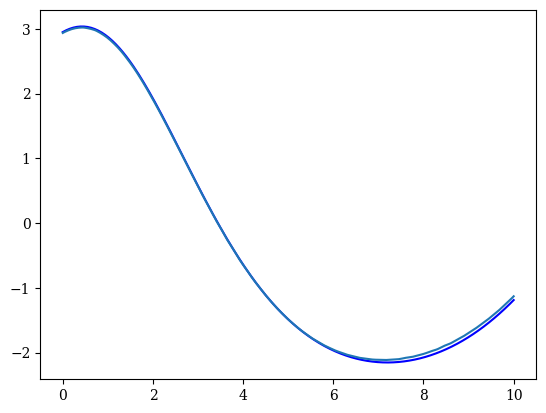

In [43]:
plt.plot(t_eval, numerical_solution[0, :], label='Numerical Solution', color='blue')
plt.plot(t_eval, transfer_model(training.generate_eval_tensor(N, t_span, False))[0].squeeze()[:, 0].detach().numpy())